<table>
    <tr style="background-color:white;">
        <td width="60%">
            <div style="height: 25px;"></div>
            <div align="left" style="color: #4b324e; font-size: 40px; font-weight: bold;">Curso de Qiskit</div>
        </td>
        <td>
            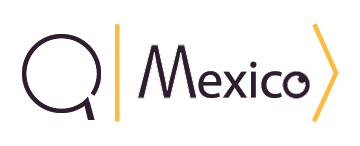
        </td>
    </tr>
</table>

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $

<div align="center" style="color: #EE2A6F; font-size: 30px; font-weight: bold;">Caracterización: Relajación y decoherencia en Qiskit</div>

<div align="right" style="font-size: 15px; font-weight: normal;">Preparado por Bruno Ramírez</div>

# Contenido

1. [Introducción](#intro)
2. [¿Qué es la relajación?](#secc1)
   1. [Definición](#secc1.1)
   2. [Herramientas de Qiskit para caracterizar la relajación](#secc1.2)
   3. [Experimento de $T_1$](#secc1.3)
3. [¿Que es la decoherencia?](#secc2)
   1. [Definición](#secc2.1)
   2. [Herramientas de Qiskit para caracterizar la decoherencia](#secc2.2)
   3. [Experimento de $T_2^*$, compuertas de Hadamard](#secc2.2)
   4. [Experimento de $T_2$, secuencias de pulsos](#secc2.2)
4. [Fuentes y material complementario](#secc3)

<a id="intro"></a>
# Introducción


Los qubits no son perfectos, presentan cierta tendencia a regresar al estado de menor energía (relajación), y a interactuar de forma irreversible con el ambiente (decoherencia).
__Estos dos procesos afectan la calidad de la información cuántica a lo largo del tiempo, por lo que es importante caracterizar cuanto tardan en suceder__. A estos tiempos se les conocen como tiempo de relajación, $T_1$ y tiempo de decoherencia, $T_2$.


<div class="alert alert-block alert-success">

**Importante: Conceptos teóricos utilizados**

Este notebook hace uso del concepto de estados cuánticos puros y mixtos, al igual que la representación de un estado cuántico mediante la matriz de densidad (denotada por $\rho$). Puedes checar estos conceptos en las fuentes incluidas en la bibliografía.

</div>

In [1]:
# Herramientas de Python auxiliares a Qiskit
import numpy as np
import matplotlib.pyplot as plt

# Herramientas de Qiskit necesarias para crear modelos de ruido
import qiskit
from qiskit.providers.aer.noise.errors.standard_errors import amplitude_damping_error
from qiskit.providers.aer.noise.errors.standard_errors import phase_damping_error
from qiskit.providers.aer.noise import NoiseModel


# Primeras importaciones de Qiskit Ignis!
from qiskit.ignis.characterization.coherence import T1Fitter, T2StarFitter, T2Fitter
from qiskit.ignis.characterization.coherence import t1_circuits, t2_circuits, t2star_circuits

<a id="secc1"></a>
# ¿Qué es la relajación?

<a id="secc1.1"></a>
## Definición

La relajación es el proceso mediante el cual un estado cuántico arbitrario $|\psi\rangle \neq |0\rangle$ tiende a regresar al estado $|0\rangle$. Este regreso se debe a la tendencia natural de un sistema físico a ocupar su estado de menor energía, en el caso de un qubit, este es el estado $|0\rangle$ ($\rho = |0\rangle\langle0|$). Es importante identificar el tiempo que éste tarda en "relajarse" al estado cero. Este tiempo es conocido como el tiempo $T_1$. 

Un qubit inicializado en $|1\rangle\langle1|$ que regresa al estado $|0\rangle\langle0|$ puede ser modelado según el siguiente comportamiento temporal:

$$ |\psi(t)\rangle \langle \psi(t)|=\rho(t)=\begin{pmatrix} (1-e^{-\Gamma_{1}t}) & 0 \\ 0 & e^{-\Gamma_{1} t}\end{pmatrix} $$ 

Dado este comportamiento, podemos preguntarnos cual es la probabilidad de encontrar el estado $\rho = |1\rangle\langle1|$ a un tiempo $t$.

$$P_1(t) = Tr\big[|1\rangle\langle1|\rho(t)\big]= e^{-\Gamma_1t} $$

Como es de esperarse, al transcurrir el tiempo es menos probable encontrar al qubit en el estado excitado. Formalmente, el tiempo $T_1$ es aquel para el cual 

$$e^{-\Gamma_1t} = e^{-1} \Rightarrow T_1 = \frac{1}{\Gamma_1}$$

Al transcurrir un tiempo $T_1$, la probabilidad de encontrar un qubit en el estado excitado es de 

$$ P_1(T_1) = 1/e \approx 0.368 $$ 

Puedes medir el tiempo de relajación $T_1$ preparando múltiples qubits en el estado excitado $\ket{1}$ y realizando mediciones para identificar cuántos de ellos siguien en dicho estado después de esperar una cantidad determinada de tiempo. Al observar el decaimiento en la población de qubits en $\ket{1}$ se puede ajustar una función para obtener el tiempo $T_1$.


<a id="secc1.2"></a>
 ## Herramientas de Qiskit para caracterizar la relajación


### Función:  `t1_circuits(num_of_gates, gate_time, qubits)`:
> __¿Qué hace?__: Proporciona los circuitos necesarios para medir $T_1$. Cada circuito prepara un qubit en el estado $\ket{1}$ y espera una cantidad creciente de tiempo aplicando cada vez más compuertas identidad ($\mathbb{I}$). Posteriormente mide el estado.
    
> __¿Qué argumentos toma?__ 
- ``num_of_gates(Union[List[int], np.array])``: Lista o arreglo de números enteros que indica la cantidad de compuertas identidad a aplicar en cada circuito.
- ``gate_time(float)``: Tiempo que tardará en ejecutar cada compuerta identidad.
- ``qubits(List[int])``: Lista de índices que indica a qué qubits se les medirá $T_1$.  
    
> __¿Qué devuelve?__

Una tupla con dos objetos: lista de objetos `QuantumCircuit` y un `array`. El primero de ellos es una lista de los circuitos cuánticos a ejecutar, el segundo es una lista con los datos de tiempo de espera. 

### Clase:  `T1Fitter(backend_result , xdata, qubits, fit_p0, fit_bounds )`:
>__¿Qué hace?__

Crea un objeto que usa los circuitos generados por la clase anterior, hace un ajuste de los datos de la forma $P_1(t) = Ae^{-t/T_1}+B$ y obtiene datos característicos del qubit (o los qubits) en cuestión, entre ellos el tiempo de relajación y la gráfica de datos.

>__¿Qué parámetros de construcción tiene?__       
- ``backend_result(Result)``: Objeto de la clase Result en Qiskit, resultado de correr los circuitos con un _backend_ seleccionado.
- ``xdata(Union[List[float], np.array])``: Lista de tiempos de retardo generada al crear los circuitos.
- ``qubits(List[int])``: Lista de índices que indica a qué qubits se les medirá $T_1$. 
- ``fit_p0(List[float])``: Valores iniciales para las variables de ajuste $A, T_1, B$
- ``fit_bounds(Tuple[List[float],List[float]])``: Cotas para los posibles valores del ajuste. La primera lista indica cotas inferiores para cada variable, la segunda lista indica las cotas superiores.


>__¿Qué construye?__

Construye un objeto que contiene los datos de las variables ajustadas, entre ellos el valor de $T_1$. Este objeto incluye un método para graficar los datos de relajación ``fit.plot(0)``
.

En pocas palabras ``t1_circuits()`` proporciona los datos necesarios para  para poder hacer un ajuste de $P_1(t)$ mediante ``T1Fitter`` y así poder calcular $T_1$. Veamos esto en acción.

<a id="secc1.3"></a>
## Código de experimento $T_1$

 El primer paso es crear un qubit cuyo comportamiento es realista, es decir que
 está sujeto a un error que provoca relajación. Adelante creamos este modelo de error

In [5]:
t1 = 25 #[µS], microsegundos
gamma = 1 - np.exp(-0.1/t1)
error = amplitude_damping_error(gamma)
noise_model = NoiseModel()
noise_model.add_quantum_error(error, 'id', [0])



Trataremos de recuperar el valor $T_1 = 25$. En este caso lo conocemos porque nosotros creamos el modelo de ruido, pero no siempre será así.

Para esperar, solo aplicamos más y más compuertas identidad que duran 0.1s. Doce números separados logarítmicamente entre 10 y 1000, agregamos un 1500 al final.

In [3]:

num_of_gates = np.append((np.logspace(1, 3, 12)).astype(int), np.array([1500]))
gate_time = 0.1 # Para tardarnos cada vez más en completar los experimentos

# Por lo general podemos medirle T1 a varios qubits, por el momento solo mediremos el T1
# del qubit 0
qubits = [0]

In [61]:
###############
# t1_circuits #
###############

#Creamos nuestra serie de experimentos para medir el T1 del qubit [0], t1_circuits
circs, datos = t1_circuits(num_of_gates, gate_time, qubits)

In [62]:
# Simulamos nuestros experimentos con el qubit realista
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 200
backend_result = qiskit.execute(circs, backend,
                                shots=shots, noise_model=noise_model).result()

[1.5003073763049282]

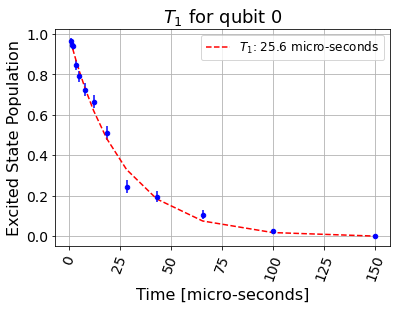

In [64]:
# Ajuste exponencial
# Parametros iniciales para el ajuste (t1=25, a=1, b = 0)

initial_t1 = t1*1.2
initial_a = 1.0
initial_c = 0.0

############
# T1Fitter #
############

fit = T1Fitter(backend_result, datos, qubits,
               fit_p0=[initial_a, initial_t1, initial_c],
               fit_bounds=([0, 0, -1], [2, initial_t1*2, 1]))

fit.plot(0)
fit.time_err(-1)

En la figura vemos los datos de población del estado excitado $\ket{1}$ como función del tiempo, una función exponencial decayente. El ajuste arroja el valor para $T_1 = 25.6$ un valor bastante aproximado al tiempo de relajación establecido en nuestro modelo de ruido.

<a id="secc2"></a>
# ¿Qué es la decoherencia? 

<a id="secc2.1"></a>
## Definición

La decoherencia es un proceso muy importante en información cuántica y se puede entender como la pérdida de información certera acerca del sistema cuántico debido a interacciones con el ambiente. Mediante la decoherencia, un **estado cuántico puro** , digamos $\rho_{+} = \ket{+}\bra{+}$, puede transformarse a un estado mixto $\rho_{50/50} = \frac{1}{2}(\ket{0}\bra{0} + \ket{1}\bra{1})$. El estado $\rho_{50/50}$ corresponde a un estado mixto comúnmente identificado como ruido, la decoherencia resulta en la transición hacia este estado.

$$ \rho_+=\frac{1}{2}\begin{pmatrix} 1 & 1 \\ 1 & 1\end{pmatrix} \to \rho_{50/50}=\frac{1}{2}\begin{pmatrix} 1 & 0 \\ 0 & 1\end{pmatrix} $$ 


Podemos modelar el proceso de decoherencia por un comportamiento temporal como el siguiente

$$ |\psi(t)\rangle \langle \psi(t)|= \rho(t)= \frac{1}{2}\begin{pmatrix} 1 & -e^{-\Gamma_{2}t} \\ -e^{-\Gamma_{2}t} & 1\end{pmatrix} $$ 

Notemos que $\rho(0) = \rho_+$ y $lim_{t\to \infty}\rho(t) = \rho_{50/50}$. Este tipo de comportamiento temporal se le atribuye a un qubit sujeto a un __canal o error de desfasamiento__.

Para un qubit con error de desfasamiento podemos caracterizar el tiempo de coherencia midiendo la probabilidad de que el qubit permanezca en el estado $\ket{+}$, haciendo

$$ P_+(t) = Tr\big[\ket{+}\bra{+}\rho(t)\big] = \frac{1}{2}(1+e^{-\Gamma_2 t})$$

Esta probabilidad se reduce al transcurrir el tiempo, pero nunca se anula. El tiempo de decoherencia $T_2$ es aquel para el cual el término exponencial tiene un exponente de $-1$, de modo que 

$$ T_2 = \frac{1}{\Gamma_2}$$

De manera similar al tiempo de relajación, este tiempo puede ser estimado preparando qubits en el estado $\ket{+}$ y midiendo su estado en la base $\{\ket{+},\ket{-}\}$ después de distintos intervalos de tiempo para obtener una curva de decaimiento en la población del estado inicial.


<a id="secc2.2"></a>
## Herramientas de Qiskit para  caracterizar la decoherencia


<div class="alert alert-block alert-success">

**Importante: Tiempos $T_2^*$ y $T_2$**

Qiskit tiene herramientas para medir el tiempo de decoherencia usando distintos métodos. Además del método discutido que involucra aplicar una compuerta $H$, los tiempos de decoherencia suelen medirse con la respuesta del qubit a distintas secuencias de pulsos, Qiskit proporciona la posibilidad de cambiar las secuencias de pulsos aplicadas para medir $T_2$. Al tiempo de decoherencia calculado mediante la aplicación de $H$ se le denota $T_2^*$ y a aquellos calculados mediante secuencias de puslos $T_2$.

</div>

__PENDIENTE A PARTIR DE ESTE PUNTO__
- La función `t2star_circuits`
- La clase `T2StarFitter`





 <a id="secc2.3"></a>
## Código de experimento $T_2^*$

Adelante veremos el primer método de estimación del tiempo de relajación. De manera similar a como se hizo con el 

<a id="secc2.4"></a>
## Código de experimento $T_2$

<a id="secc3"></a>
# Referencias
***
- [1] Nation, P. (2021, June 22). Qiskit Tutorials: Relaxation and Decoherence. Consultado el 25 de junio de 2021, en https://qiskit.org/documentation/tutorials/noise/2_relaxation_and_decoherence.html
- [2]
- [3]